# Linear Learner 내장 알고리즘을 통한 시계열 예측

이 노트북은 아래의 원본 노트북을 기반으로 번역 및 첨삭을 하였습니다. 상세한 내용은 원본을 참고 하세요.

- Time Series Forecasting with Linear Learner
    - Using Linear Regression to Forecast Monthly Demand
    - https://github.com/aws/amazon-sagemaker-examples/blob/master/introduction_to_applying_machine_learning/linear_time_series_forecast/linear_time_series_forecast.ipynb

---

---

## Contents

1. [Background](#Background)
- 노트북의 문제에 대한 배경 설명을 합니다.

2.[Setup](#Setup)
- S3 버킷 및 IAM role을 정의 합니다.
3. [Data](#Data)
- 미국 가솔린 수요 주간 데이터를 다운로드 합니다.
- 데이터를 훈련, 검증, 테스트 데이터로 분리 합니다.
- 세이지 메이커의 내장 알고리즘이 사용할 수 있는 protobuf 포맷으로 변경 합니다.
- 데이터를 S3로 업로드 합니다.
4. [Train](#Train)
- 내장 알고리즘을 훈련 합니다.
5. [Host](#Host)
- 앤드 포인트를 생성 합니다
  1). [Forecast](#Forecast)
  - 추론을 진행 합니다.  
6. [Extensions](#Extensions)

---

## Background
이 섹션에서는 아래와 같은 중요한 포인트가 있습니다.

- 일반적으로 시계열 데이터의 모델링은 많은 주의가 필요합니다. 모델링시에 어느 정도 수준의 합산(Aggregation)이 좋을까? 너무 작은 레벨 합산은 값들의 시그널이 노이즈속에서 잃게 됩니다. 반면에 너무 높은 레벨의 합산은 중요한 값들의 변화(Variation)을 잃어 버립니다. 또한 옳은 주기(Cyclicality)는 무엇일까요? 일별, 주별, 월별? 휴일의 큰 고점들이 있나? 우리가 어떻게 최근 데이터에 가중치를 주어야 하고, 전반적인 트랜드에 가중치를 줄 수 있을까?

- 트랜드, 계절성, 최근 시점에 대한 적당한 제어를 하게 되면 Linear Regression은 합리적인 결과를 낼 수 있는 방법 입니다.
- 이 노트북은 1991년 부터 2005년 까지의 미국 가솔린 제품의 생산량을 예측하는 linear model을 만들게 됩니다. 포케스팅의 깊은 이해를 위해서는 아래 URL을 참조 바랍니다. [Forecasting: Principles & Practice](https://robjhyndman.com/uwafiles/fpp-notes.pdf)
- 우리가 사용하는 데이터 세트가 한개의 시계열 데이터이기에 SageMaker의 Linear Learner 알고리즘을 사용하였고, 만약 우리가 다수의 시계열 데이터 및 관계되는 시계열 데이터를 가졌다면, 우리는 SageMaker's DeepAR 알고리즘을 사용 했을 겁니다. 자세한 것은 다음을 참조 하세요 [DeepAR Notebook](https://github.com/awslabs/amazon-sagemaker-examples/blob/master/introduction_to_amazon_algorithms/deepar_synthetic/deepar_synthetic.ipynb)

---

## Setup
- 이 노트북은 ml.m4.xlarge 에서 생성 및 테스트 되었습니다.


In [1]:
import sagemaker
bucket = sagemaker.Session().default_bucket() # 디폴트 버킷 사용

In [2]:
# bucket = '<your_s3_bucket_name_here>'
prefix = 'sagemaker/DEMO-linear-time-series-forecast'
 
# Define IAM role
import boto3
import re
from sagemaker import get_execution_role

role = get_execution_role()

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import io
import os
import time
import json
import sagemaker.amazon.common as smac
import sagemaker
from sagemaker.predictor import csv_serializer, json_deserializer

---
## Data

데이터를 다운로드 합니다. 자세한 데이타의 설명은 여기를 보세요. [here](https://rdrr.io/github/robjhyndman/fpp/man/gasoline.html).

In [4]:
!wget http://robjhyndman.com/data/gasoline.csv

--2020-12-04 14:16:14--  http://robjhyndman.com/data/gasoline.csv
Resolving robjhyndman.com (robjhyndman.com)... 35.208.79.31
Connecting to robjhyndman.com (robjhyndman.com)|35.208.79.31|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://robjhyndman.com/data/gasoline.csv [following]
--2020-12-04 14:16:15--  https://robjhyndman.com/data/gasoline.csv
Connecting to robjhyndman.com (robjhyndman.com)|35.208.79.31|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4530 (4.4K) [text/csv]
Saving to: ‘gasoline.csv.2’

gasoline.csv.2      100%[===================>]   4.42K  --.-KB/s    in 0s      

2020-12-04 14:16:16 (759 MB/s) - ‘gasoline.csv.2’ saved [4530/4530]



데이터를 로딩하고 확인 합니다.

,thousands_barrels
0,6621.0
1,6433.0
2,6582.0
3,7224.0
4,6875.0


data shape:  (745, 1)


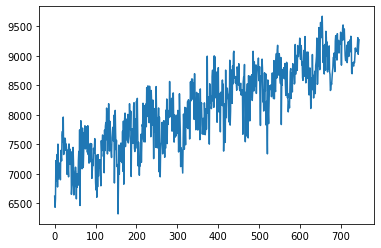

In [5]:
gas = pd.read_csv('gasoline.csv', header=None, names=['thousands_barrels'])
display(gas.head())
print("data shape: ", gas.shape)
plt.plot(gas)
plt.show()

데이터의 포인트:
- 시계열은 상승 트랜드를 가지고 있다.
- 년에 대한 계절성을 가지고 있다. 하지만 충분한 데이타의 높고 낮음의 변동성을 보여서 쉬운 문제는 아닙니다.
- 예상지 않은 급격한 하락 및 다소 pronounced seasonality(?) 가 있습니다.

위의 관찰을 바탕으로 아래와 같이 데이터를 변환 합니다.
- 우리의 타겟 변수는 thousands_barrels 입니다.
- 설명 변수를 아래와 같이 만듭니다.
    - thousands_barrels 에 대한 최근 4주 값
    - 트랜드. 위의 차트는 트랜드가 선형성을 보이지만, 우리는 로그 및 quadratic trends를 만들겁니다.
    - 플래그 변수인 (0 혹은 1) 은 계절성 및 주요한 휴일 주에 대해서 도움을 줄 수 있습니다.


In [6]:
# 최근 4주의 값을 얻음
gas['thousands_barrels_lag1'] = gas['thousands_barrels'].shift(1)
gas['thousands_barrels_lag2'] = gas['thousands_barrels'].shift(2)
gas['thousands_barrels_lag3'] = gas['thousands_barrels'].shift(3)
gas['thousands_barrels_lag4'] = gas['thousands_barrels'].shift(4)
# 트랜드 데이터를 얻음
gas['trend'] = np.arange(len(gas))
gas['log_trend'] = np.log1p(np.arange(len(gas)))
gas['sq_trend'] = np.arange(len(gas)) ** 2
# 52주 * 15의 값을 반복적으로 구한 후에 gas의 레코드 갯수 (745개) 만큼의 weeks 변수를 만듦
weeks = pd.get_dummies(np.array(list(range(52)) * 15)[:len(gas)], prefix='week')
gas = pd.concat([gas, weeks], axis=1) # gas와 weeks 데이터를 합침

In [7]:
print("gas :",gas.shape)
print(gas.columns)

gas : (745, 60)
Index(['thousands_barrels', 'thousands_barrels_lag1', 'thousands_barrels_lag2',
       'thousands_barrels_lag3', 'thousands_barrels_lag4', 'trend',
       'log_trend', 'sq_trend', 'week_0', 'week_1', 'week_2', 'week_3',
       'week_4', 'week_5', 'week_6', 'week_7', 'week_8', 'week_9', 'week_10',
       'week_11', 'week_12', 'week_13', 'week_14', 'week_15', 'week_16',
       'week_17', 'week_18', 'week_19', 'week_20', 'week_21', 'week_22',
       'week_23', 'week_24', 'week_25', 'week_26', 'week_27', 'week_28',
       'week_29', 'week_30', 'week_31', 'week_32', 'week_33', 'week_34',
       'week_35', 'week_36', 'week_37', 'week_38', 'week_39', 'week_40',
       'week_41', 'week_42', 'week_43', 'week_44', 'week_45', 'week_46',
       'week_47', 'week_48', 'week_49', 'week_50', 'week_51'],
      dtype='object')


In [8]:
gas

,thousands_barrels,thousands_barrels_lag1,thousands_barrels_lag2,thousands_barrels_lag3,thousands_barrels_lag4,trend,log_trend,sq_trend,week_0,week_1,...,week_42,week_43,week_44,week_45,week_46,week_47,week_48,week_49,week_50,week_51
0,6621.0,NaN,NaN,NaN,NaN,0,0.000000,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,6433.0,6621.0,NaN,NaN,NaN,1,0.693147,1,0,1,...,0,0,0,0,0,0,0,0,0,0
2,6582.0,6433.0,6621.0,NaN,NaN,2,1.098612,4,0,0,...,0,0,0,0,0,0,0,0,0,0
3,7224.0,6582.0,6433.0,6621.0,NaN,3,1.386294,9,0,0,...,0,0,0,0,0,0,0,0,0,0
4,6875.0,7224.0,6582.0,6433.0,6621.0,4,1.609438,16,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
740,9170.0,9089.0,9095.0,9075.0,9069.0,740,6.608001,547600,0,0,...,0,0,0,0,0,0,0,0,0,0
741,9306.0,9170.0,9089.0,9095.0,9075.0,741,6.609349,549081,0,0,...,0,0,0,0,0,0,0,0,0,0
742,9024.0,9306.0,9170.0,9089.0,9095.0,742,6.610696,550564,0,0,...,0,0,0,0,0,0,0,0,0,0
743,9175.0,9024.0,9306.0,9170.0,9089.0,743,6.612041,552049,0,0,...,0,0,0,0,0,0,0,0,0,0


데이터 분리:
- 최근 4주의 데이터를 설명 변수로 만들었기에, 최초 4개의 레코드는 삭제 합니다. (왜냐하면 4개의 설명 변수가 하나 이상은 NULL 이이서 입니다.)
- 타겟 변수를 설명 변수와 분리 합니다.
- 데이터를 6:2:2 비율로 훈련, 검증, 테스트 데이터로 분리 합니다.

In [9]:
gas = gas.iloc[4:, ] # 최신 4개를 삭제하고 재 저장
split_train = int(len(gas) * 0.6) # 훈련 60%
split_test = int(len(gas) * 0.8) # 테스트 20%

# 훈련 데이터
train_y = gas['thousands_barrels'][:split_train] # 타겟 값 추출
train_X = gas.drop('thousands_barrels', axis=1).iloc[:split_train, ].to_numpy() # 설명 변수만 추출
# 검증 데이터
validation_y = gas['thousands_barrels'][split_train:split_test]
validation_X = gas.drop('thousands_barrels', axis=1).iloc[split_train:split_test, ].to_numpy()
# 테스트 데이터
test_y = gas['thousands_barrels'][split_test:]
test_X = gas.drop('thousands_barrels', axis=1).iloc[split_test:, ].to_numpy()

이제 우리는 아래와 같은 작업을 할 겁니다.
- 데이터 세트를 recordIO-wrapped protobuf 포맷으로 변경. 이유는 Amazon SageMaker algorithms이 이 포맷을 사용 합니다.
- 변환된 데이터를 S3에 업로드 합니다.
- 우리는 훈련을 시작합니다.


## Protobuf 포맷으로 변환

### 훈련 데이터 포맷 변경 및 업로드

In [10]:
buf = io.BytesIO()
smac.write_numpy_to_dense_tensor(buf, np.array(train_X).astype('float32'), np.array(train_y).astype('float32'))
buf.seek(0)

0

In [11]:
key = 'linear_train.data'
boto3.resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'train', key)).upload_fileobj(buf)
s3_train_data = 's3://{}/{}/train/{}'.format(bucket, prefix, key)
print('uploaded training data location: {}'.format(s3_train_data))

uploaded training data location: s3://sagemaker-ap-northeast-2-057716757052/sagemaker/DEMO-linear-time-series-forecast/train/linear_train.data


### 검증 데이터 포맷 변경 및 업로드

In [12]:
buf = io.BytesIO()
smac.write_numpy_to_dense_tensor(buf, np.array(validation_X).astype('float32'), np.array(validation_y).astype('float32'))
buf.seek(0)

0

In [13]:
key = 'linear_validation.data'
boto3.resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'validation', key)).upload_fileobj(buf)
s3_validation_data = 's3://{}/{}/validation/{}'.format(bucket, prefix, key)
print('uploaded validation data location: {}'.format(s3_validation_data))

uploaded validation data location: s3://sagemaker-ap-northeast-2-057716757052/sagemaker/DEMO-linear-time-series-forecast/validation/linear_validation.data


---
## Train

아래는 SageMaker의 내장 알고리즘의 컨테이너를 (프레임워크 + 알고리즘 정의 및 학습 코드) 가져 옵니다.
자세한 정보는 아래를 보세요. [AWS documentation](https://docs.aws.amazon.com/sagemaker/latest/dg/sagemaker-algo-docker-registry-paths.html).

In [14]:
from sagemaker.amazon.amazon_estimator import get_image_uri
container = get_image_uri(boto3.Session().region_name, 'linear-learner')

The method get_image_uri has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.


Amazon SageMaker's Linear Learner 은 병렬오 다수의 모델 조금씩 다른 하이퍼파라미터의 값을 가지고 훈련 합니다. 그리고 가장 최적으로 훈련된 모델을 제공 합니다. 이 옵션은 디폴트로 제공 합니다.
아래와 같은 하이퍼 파라미터를 사용합니다. 아래의 정의는 일부 원문을 번역없이 두었습니다.

- `num_models`: 몇 개의 모델을 병렬로 훈련할지를 정합니다. 32개가 max 값 입니다.
- `loss`: which controls how we penalize mistakes in our model estimates.  For this case, let's use absolute loss as we haven't spent much time cleaning the data, and absolute loss will adjust less to accomodate outliers.
- `wd` or `l1` which control regularization.  Regularization can prevent model overfitting by preventing our estimates from becoming too finely tuned to the training data, which can actually hurt generalizability.  In this case, we'll leave these parameters as their default "auto" though.



In [15]:
sess = sagemaker.Session()

linear = sagemaker.estimator.Estimator(container,
                                       role, 
                                       train_instance_count=1, 
                                       train_instance_type='ml.c4.xlarge',
                                       output_path='s3://{}/{}/output'.format(bucket, prefix),
                                       sagemaker_session=sess)
linear.set_hyperparameters(feature_dim=59,
                           mini_batch_size=100,
                           predictor_type='regressor',
                           epochs=10,
                           num_models=32,
                           loss='absolute_loss')

linear.fit({'train': s3_train_data, 'validation': s3_validation_data})

train_instance_count has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_instance_type has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


2020-12-04 14:17:53 Starting - Starting the training job...
2020-12-04 14:17:55 Starting - Launching requested ML instances......
2020-12-04 14:19:05 Starting - Preparing the instances for training......
2020-12-04 14:20:07 Downloading - Downloading input data...
2020-12-04 14:20:52 Training - Training image download completed. Training in progress..Docker entrypoint called with argument(s): train
Running default environment configuration script
[12/04/2020 14:20:56 INFO 140207823968064] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'loss_insensitivity': u'0.01', u'epochs': u'15', u'feature_dim': u'auto', u'init_bias': u'0.0', u'lr_scheduler_factor': u'auto', u'num_calibration_samples': u'10000000', u'accuracy_top_k': u'3', u'_num_kv_servers': u'auto', u'use_bias': u'true', u'num_point_for_scaler': u'10000', u'_log_level': u'info', u'quantile': u'0.5', u'bias_lr_mult': u'auto', u'lr_scheduler_step': u'auto', u'init_

---
## Host
- 우리가 정의한 데이터로 the linear algorithm을 훈련 시켰습니다. (가중치가 타겟값에 최적화 되게 가중치 값을 확정)
- 모델을 생성하고 호스팅된 Endpoint (EC2 instance)에 배포 할겁니다.

아래는 약 6-10 분 정도 소요 됩니다.

In [16]:
%%time
linear_predictor = linear.deploy(initial_instance_count=1,
                                 instance_type='ml.m4.xlarge')

---------------!

### Forecast

우리는 이제 엔드포인트를 가졌습니다. 그래서 통계적 예측을 할 수 있습니다. 테스트 데이터 세트로 생성한 모델이 얼마나 정확한지 알아 봅니다.
예측 에러를 측정하기 위해서는 여러 지표가 있습니다. 일반적인 지표는 아래와 같습니다.

- Root Mean Square Error (RMSE)
- Mean Absolute Percent Error (MAPE)
- Geometric Mean of the Relative Absolute Error (GMRAE)
- Quantile forecast errors
- Errors that account for asymmetric loss in over or under-prediction

우리는 심플하게 진행하겠습니다. 그래서 Median Absolute Percent Error (MdAPE) 를 사용하겠습니다. 기본 베이스 라인 (Naive 벤츠마크)를 아래와 같이 정의 하겠습니다.
- **Naive Benchmark = 해당 주의 1년 전의 값의 제곱 / 해당 주의 2년 전의 값**

아래 두 가지의 예측 방법이 있습니다.
- One-step-ahead forecasts (미래 하나의 지점을 예측)
    - 해당 시점까지 수집된 데이터로 설명 변수를 만들고 미래의 하나의 지점 값을 예측 합니다. 단점으로는 현실적으로 데이터를 해당 지점까지 수집하는 것이 어려울 수 있습니다.


- Multi-step-ahead (or horizon) forecasts (미래의 여러개의 지점을 예측)
    - 해당 시점까지 수집된 데이터로 설명 변수를 만들고, 미래의 하나의 지점 값을 예측 합니다. 이 예측값을 바탕으로 또 설명 변수를 만들고 또 미래의 하나의 지점 값을 예측 합니다. 이렇게 반복을 하게 됩니다. 현실적으로 데이터 수집을 하고 진행할 수 있습니다. 하지만 예측된 값을 사용하여 설명 변수로 계속 사용하기에 에러가 누적이 되어서 예측의 결과는 시간이 갈수록 떨어지게 됩니다,

우리는 위의 두가지 방법을 사용하여 예측 해보겠습니다.

#### Naive forecast 구하기

In [17]:
gas['thousands_barrels_lag52'] = gas['thousands_barrels'].shift(52)
gas['thousands_barrels_lag104'] = gas['thousands_barrels'].shift(104)
gas['thousands_barrels_naive_forecast'] = gas['thousands_barrels_lag52'] ** 2 / gas['thousands_barrels_lag104']
naive = gas[split_test:]['thousands_barrels_naive_forecast'].to_numpy()

MAPE (Mean Absolute Percentage Error)를 진실값과 Navie값을 통하여 구한 다음에 에러율의 분포를 확인 합니다.

596    0.040971
597    0.112019
598    0.035734
599    0.014352
600    0.079688
         ...   
740    0.004948
741    0.101254
742    0.000559
743    0.076599
744    0.002288
Name: thousands_barrels, Length: 149, dtype: float64


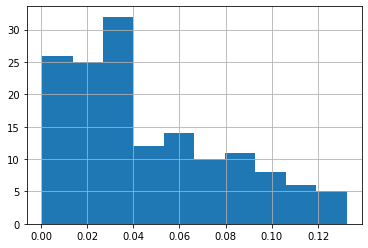

In [18]:
perf_percent = np.abs(test_y - naive) / test_y
print(perf_percent)
perf_percent.hist()

MdAPE 의 값을 구하고 차트로 표시 합니다.

Naive MdAPE = 0.03687277085962615


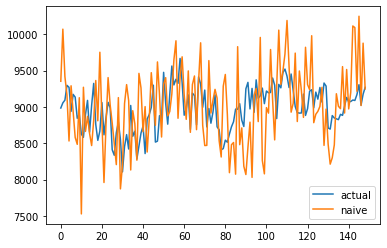

In [19]:
print('Naive MdAPE =', np.median(np.abs(test_y - naive) / test_y))
plt.plot(np.array(test_y), label='actual')
plt.plot(naive, label='naive')
plt.legend()
plt.show()

## 추론 작업
이제 우리는 one-step-ahead forecast를 추론 할겁니다.
- 먼저  Numpy Array 를 HTTP POST 요청으로 Endpoint에 제공할 수 있는 포맷 (CSV String) 으로 변환할 겁니다.
- Endpoint는 HTTP POST로 받은 요청을 내부의 inference container로 전달합니다.
- inference container 는 추론을 하여 결과를 JSON 포맷으로 엔드포인트에게 제공합니다.
- Endpoint는 JSON 포맷으로 최종 결과를 반환 합니다.

이를 위해서 우리는 Amazon SageMaker Python SDK's built in `CSVSerializer` and `JSONDeserializer` 를 사용합니다.


In [20]:
from sagemaker.deserializers import JSONDeserializer
from sagemaker.serializers import CSVSerializer
CSVSerializer.CONTENT_TYPE = 'text/csv'

# ntm_predictor.content_type = 'text/csv'

In [21]:
linear_predictor.serializer = CSVSerializer()
linear_predictor.deserializer = JSONDeserializer()

# linear_predictor.content_type = 'text/csv'
# linear_predictor.serializer = csv_serializer
# linear_predictor.deserializer = json_deserializer

테스트 데이터를 준비하고, 엔드포인트의 인터페이스 오브젝트인 linear_predictor 의 predict()를 호출합니다.

In [22]:
test_X.shape

(149, 59)

In [23]:
test_X

array([[9004., 9172., 8752., ...,    0.,    0.,    0.],
       [8985., 9004., 9172., ...,    0.,    0.,    0.],
       [9056., 8985., 9004., ...,    0.,    0.,    0.],
       ...,
       [9306., 9170., 9089., ...,    0.,    0.,    0.],
       [9024., 9306., 9170., ...,    0.,    0.,    0.],
       [9175., 9024., 9306., ...,    0.,    0.,    0.]])

In [24]:
result = linear_predictor.predict(test_X)
one_step = np.array([r['score'] for r in result['predictions']])

In [27]:
print((len(result['predictions'])))
print(one_step.shape)
print("one_step predictions: \n", one_step)

149
(149,)
one_step predictions: 
 [9091.63671875 8944.890625   9124.87890625 8960.87304688 9069.40917969
 9061.25976562 8958.93554688 8956.078125   8892.75976562 8846.9765625
 8784.31445312 8964.5703125  8828.30078125 8882.95410156 8902.53808594
 8782.52929688 8868.65429688 9005.95703125 8836.34179688 8714.25
 8959.33398438 8921.12890625 8977.32226562 8784.9375     8631.72167969
 8717.984375   8607.42773438 8600.94726562 8568.81640625 8634.45117188
 8681.24609375 8805.84570312 8520.72460938 8571.1875     8845.7734375
 8782.02148438 8743.9453125  8747.91210938 8857.79882812 8801.99316406
 8818.84179688 8761.31445312 8776.828125   8941.68066406 9048.75976562
 8885.34375    9077.91796875 9026.88085938 9081.64257812 9111.875
 8996.44921875 9022.35742188 9281.09960938 9088.66015625 9256.734375
 9128.5234375  9254.19140625 9232.46289062 9169.94628906 9178.90820312
 9137.39453125 9068.50195312 8978.78808594 9158.53320312 9052.23828125
 9081.4296875  9133.82226562 8953.22265625 9067.44140625 

One-step-ahead MdAPE =  0.020360223119258346


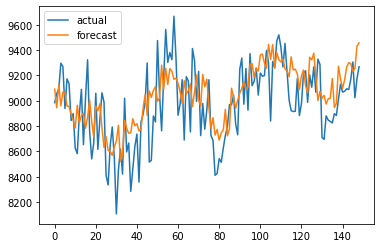

In [28]:
print('One-step-ahead MdAPE = ', np.median(np.abs(test_y - one_step) / test_y))
plt.plot(np.array(test_y), label='actual')
plt.plot(one_step, label='forecast')
plt.legend()
plt.show()

MdAPE는 naive(0.036) 보다 상당히 좋습니다. 하지만 실제 데이터의 강하게 낮고 높은 부분에 대해서는 잘 피팅이 안되고 있습니다. 일번적인 과점에서는 예측 결과가 실제 데이터를 어느정도 표현한다고 볼수 있습니다.

### multi-step-ahead forecast
엔드포인트를 하나의 레코드씩 반복해서 호출 합니다.

In [30]:
multi_step = []
lags = test_X[0, 0:4]
print("the first row's lags: ", lags)
for row in test_X:
    row[0:4] = lags # 현재의 W-1 ~ W-4 까지의 값을 대체
    result = linear_predictor.predict(row)
    prediction = result['predictions'][0]['score']
    multi_step.append(prediction)
    lags[1:4] = lags[0:3] # 바로 전주 (W-1 ~ W-3) 을 W-2 ~ W-4 로 대체
    lags[0] = prediction # 바로 전 주의 값을 (W-1) 현재 예측값으로 대체

multi_step = np.array(multi_step)

the first row's lags:  [9537.63085938 9484.41210938 9318.26757812 9310.40429688]


Multi-step-ahead MdAPE = 0.021905220272206302


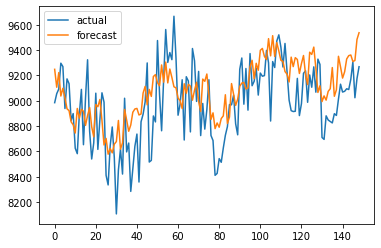

In [31]:
print('Multi-step-ahead MdAPE =', np.median(np.abs(test_y - multi_step) / test_y))
plt.plot(np.array(test_y), label='actual')
plt.plot(multi_step, label='forecast')
plt.legend()
plt.show()

위의 에러는 one-step ahead forecast 보다는 더 발생합니다. 하지만 naive 보다는 훨씬 좋습니다. 

---
## Extension

우리의 linear model은 가솔린 수요 예측을 수행했습니다. 그러나 개선점은 분명히 있습니다. 통계적 예측이 데이터의 심한 높고 낮음에 대해서 잘 표현을 못한다는 사실은 우리의 예측이 너무 over-regularized 되어 있을 수 있습니다. 혹은 우리의 loss function 인 absolute loss의 선택이 틀릴 수 있습니다. 하이퍼라라미터를 조금더 튜닝하면 더 좋을 결과가 나올 수도 있습니다. 또한 피쳐 엔지니어링 작업을 더하면 더 나아질 수 있습니다. 복잡한 lagging time-periods가 서로 관계를 만드는데 이점도 더욱 탐색할 필요가 있습니다. 설명력이 약한 ARIMA, LSTM 이 더 좋은 결과를 보이고 있습니다. Linear model의 간단함과 예측 정확도를 주어지는 비즈니스 과제에 따라 사용할 수 있습니다.


### (Optional) Clean-up

이 노트북을 다 사용했다고 하면, 아래 엔드포인트 리소스를 지워주시기 바랍니다.(그렇지 않으면 계속 비용이 발생합니다.)

In [32]:
# sagemaker.Session().delete_endpoint(linear_predictor.endpoint)